# CalendarFlops

In [1]:
!python -m spacy download de

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /opt/conda/lib/python3.6/site-packages/de_core_news_sm -->
    /opt/conda/lib/python3.6/site-packages/spacy/data/de

    You can now load the model via spacy.load('de')



In [2]:
from torchtext.data import Dataset, BucketIterator, Field, TabularDataset, Iterator
from torchtext.vocab import Vocab
import pandas as pd
import numpy as np
import spacy

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
import torch.nn.utils.rnn as rnn_utils
from torchtext.vocab import Vectors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
## Read set
#data='../datasets/TalentFox/processed_dataset-small.csv'
data='../datasets/TalentFox/processed_dataset.csv'

parced_data = pd.read_csv(data)
parced_data = parced_data[['candidate_resume','job_description', 'match_status']]
parced_data['match_status'] = parced_data['match_status'][pd.to_numeric(parced_data['match_status'], errors='coerce').notnull()]
parced_data = parced_data.dropna()

#Flat
parced_data['match_status'] = parced_data['match_status'].apply(lambda x: 0 if int(x) < 4 else 1)

# Drop to equal
parced_data = parced_data.sort_values(by=['match_status'], ascending=False)
count = pd.value_counts(parced_data['match_status'].values, sort=False)
count = count[1]
parced_data = parced_data[:2*count]

# Shuffle
parced_data = parced_data.sample(frac=1)

max_length_candidates = max((len(s.split(' ')) for s in parced_data['candidate_resume']))
max_length_jobs = max((len(s.split(' ')) for s in parced_data['job_description']))

sizes = [0.7, 0.2]
n = len(parced_data)

train_size = int(sizes[0] * n)
val_size = int(sizes[1] * n)
test_size = n - train_size - val_size

train = parced_data[:train_size]
val = parced_data[train_size:train_size+val_size]
test = parced_data[train_size+val_size:]

val.to_csv('../datasets/TalentFox/val.csv', header = False, index = False)
test.to_csv('../datasets/TalentFox/test.csv', header = False, index = False)
train.to_csv('../datasets/TalentFox/train.csv', header = False, index = False)

In [5]:
spacy_de = spacy.load('de')

vec_url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.de.vec'

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_de.tokenizer(text)]

CANDIDATES = Field(sequential=True, lower=True, include_lengths=True, fix_length=max_length_candidates)
LABEL = Field(sequential=False, use_vocab=False)
JOBS = Field(sequential=True, lower=True, include_lengths=True, fix_length=max_length_jobs)

train, val, test = TabularDataset.splits(
        path='../datasets/TalentFox', train='train.csv',
        validation='val.csv', test='test.csv', format='csv',
        fields=[('Candidates', CANDIDATES), ('Jobs', JOBS), ('Label', LABEL)])

CANDIDATES.build_vocab(train, vectors=Vectors('wiki.de.vec', url=vec_url))
LABEL.build_vocab(train)
JOBS.build_vocab(train, vectors=Vectors('wiki.de.vec', url=vec_url))

In [6]:
print('Text fields:')
print(f' Size of  job vocabulary: {len(JOBS.vocab)}')
print(f' Size of users vocabulary: {len(CANDIDATES.vocab)}')
print(' no. times the "das" appear in the dataset:', JOBS.vocab.freqs['das']+CANDIDATES.vocab.freqs['das'])
print(f' Max length: Candidates: {max_length_candidates}, Jobs: {max_length_jobs}')

Text fields:
 Size of  job vocabulary: 7892
 Size of users vocabulary: 20938
 no. times the "das" appear in the dataset: 206
 Max length: Candidates: 3541, Jobs: 351


In [7]:
batch_size = (10, 11, 12)

train_iter, val_iter, test_iter = BucketIterator.splits(
    (train, val, test), batch_sizes = batch_size, sort_key=lambda x: len(x.Jobs), sort_within_batch = True)

In [8]:
# size of embeddings
embedding_dim_candidates = CANDIDATES.vocab.vectors.size()[1]
embedding_dim_jobs = JOBS.vocab.vectors.size()[1]
num_jobs = JOBS.vocab.vectors.size()[0]
num_candidates = CANDIDATES.vocab.vectors.size()[0]
print(f'Number of candidates: {num_candidates}, Number of jobs: {num_jobs}')

print(f'Candidates embedding dim {embedding_dim_candidates}')
print(f'Job embedding dim {embedding_dim_jobs}')

n_hidden = 91
l1_hidden = 500

Number of candidates: 20938, Number of jobs: 7892
Candidates embedding dim 300
Job embedding dim 300


In [9]:
class CFNN(nn.Module):
    def __init__(self, num_candidates,
                 num_jobs,
                 embedding_dim_candidates=embedding_dim_candidates,
                 embedding_dim_jobs=embedding_dim_jobs,
                 n_hidden=n_hidden,
                 l1_hidden=l1_hidden):
        super(CFNN, self).__init__()
        
        self.candidates_emb = nn.Embedding(num_candidates, embedding_dim_candidates)       
        self.jobs_emb = nn.Embedding(num_jobs, embedding_dim_jobs)
               
        self.lin1 = nn.Linear(embedding_dim_candidates + embedding_dim_jobs, l1_hidden)
        self.lin2 = nn.Linear(l1_hidden, 1)
        self.drop0 = nn.Dropout(0.1)
        self.drop1 = nn.Dropout(0.1)
                
        ### RNN decoding
        # Candidates
        self.rnn_candidates = nn.LSTM(embedding_dim_candidates, n_hidden, batch_first = False)
        self.rnnlin_candidates = nn.Linear(embedding_dim_candidates, n_hidden)
        
        # Jobs
        self.rnn_jobs = nn.LSTM(embedding_dim_jobs, n_hidden, batch_first = False)
        self.rnnlin_jobs = nn.Linear(100, n_hidden)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, c, j, hidden_candidates, hidden_jobs, candidates_length, job_length):
        C = self.candidates_emb(c)
        J = self.jobs_emb(j)
        batch_size = len(candidates_length)
        
        # Masking and meaning Candidates
        mask_candidates = list()
        for i in range(batch_size):
            l = candidates_length.data[0].item()
            m = [1]*l + [0]*(max_length_candidates-l)
            mask_candidates += [m]       
        mask_candidates = torch.from_numpy(np.array(mask_candidates)).to(device).float().transpose(0,1)             
        mask_candidates = mask_candidates.unsqueeze(2)
        
        C = C * mask_candidates
        C = C.sum(0)/candidates_length.unsqueeze(1).float().to(device)

        # Masking and meaning Jobs
        mask_jobs = list()
        for i in range(batch_size):
            l = job_length.data[0].item()
            m = [1]*l + [0]*(max_length_jobs-l)
            mask_jobs += [m]       
        mask_jobs = torch.from_numpy(np.array(mask_jobs)).to(device).float().transpose(0,1)
        mask_jobs = mask_jobs.unsqueeze(2)
        
        J = J * mask_jobs
        J = J.sum(0)/job_length.unsqueeze(1).float().to(device)
        
        x = torch.cat([C, J], dim=1)
        
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))

        x = self.sigmoid(x)
        return x
    
    def init_hidden_candidates(self, batch_size):
        init = torch.zeros(1, batch_size, n_hidden).to(device)
        return (init,init)
    
    def init_hidden_jobs(self, batch_size):
        init = torch.zeros(1, batch_size, n_hidden).to(device)
        return (init,init)

In [10]:
## Training loop
def train(model, train_loader, optimizer, criterion, epoch, print_batch_p):
    model.train()
    
    TP,FP,TN,FN = 0,0,0,0
    loss_list = []
    
    for batch_idx, (data, _) in enumerate(train_loader):
        (candidates, candidates_length), (jobs, job_length), ratings = data
                   
        batch_s = len(candidates_length)
        
        candidates = candidates.long().to(device)
        jobs = jobs.long().to(device)
        ratings = ratings.float().to(device)      
        ratings = ratings.view(-1)
        
        optimizer.zero_grad()
        hidden_init_candidates = model.init_hidden_candidates(batch_s)
        hidden_init_jobs = model.init_hidden_jobs(batch_s)
        output = model(candidates, jobs, hidden_init_candidates, hidden_init_jobs, candidates_length, job_length)
        output = output.view(-1)
        
        loss = criterion(output, ratings)
        loss.backward()
        optimizer.step()
        
        # Print jumping
        percent = print_batch_p
        
        proc = int((len(train_loader.dataset)/batch_s)*percent)
        proc = proc if proc >= 1 else 1
        
        # Calculate accuracy
        output_flat = [0 if o < 0.5 else 1 for o in output.data]

        for y,yhat in zip(ratings.data, output_flat):
            y = int(y)
            if yhat == 0:
                if y != yhat:
                    FN += 1
                else:
                    TN += 1
            else:
                if y != yhat:
                    FP += 1
                else:
                    TP += 1
        loss_list += [loss.item()]
        
        if batch_idx % proc == 0 and batch_idx != 0:
            loss_mean = sum(loss_list)/len(loss_list)
            acc = (TP + TN)/(TP+FP+TN+FN)
            
            if TP + FN == 0:
                recall = 0    
            else:       
                recall = TP/(TP + FN)
                
            if TP + FP == 0:
                precision = 0
            else:
                precision = TP/(TP + FP)
            
            
            if recall + precision == 0:
                F1_score = 0
            else:
                F1_score = 2/(1/recall + 1/precision)
            
            #TP,FP,TN,FN = 0,0,0,0
            #loss_list = []
            print(f'Train epoch {epoch} ({100 * (batch_idx / len(train_loader)):.0f}%), Mean Loss: {loss_mean:.2f}, F1: {F1_score:.2f}')


def validate(model, val_loader, criterion, epoch):
    model.eval()
    outputlist = []
    val_loss = 0
    TP,FP,TN,FN = 0,0,0,0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            (candidates, candidates_length), (jobs, job_length), ratings = data
            batch_s = len(candidates_length)
            
            candidates = candidates.long().to(device)
            jobs = jobs.long().to(device)
            ratings = ratings.float().to(device)
            
            ratings = ratings.unsqueeze(1)
            hidden_init_candidates = model.init_hidden_candidates(batch_s)
            hidden_init_jobs = model.init_hidden_jobs(batch_s)
            
            output = model(candidates, jobs, hidden_init_candidates, hidden_init_jobs, candidates_length, job_length)
            output_flat = [0 if o < 0.5 else 1 for o in output.data]
            
            for y,yhat in zip(ratings.data, output_flat):
                y = int(y)
                if yhat == 0:
                    if y != yhat:
                        FN += 1
                    else:
                        TN += 1
                else:
                    if y != yhat:
                        FP += 1
                    else:
                        TP += 1
        
            outputlist += [output]
            val_loss += criterion(output, ratings).item() # sum up batch loss

    #print(TP, FN)
    acc = (TP + TN)/(TP + TN + FP + FN)
    
    if TP + FN == 0:
        recall = 0    
    else:       
        recall = TP/(TP + FN)

    if TP + FP == 0:
        precision = 0
    else:
        precision = TP/(TP + FP)

    if recall + precision == 0:
        F1_score = 0
    else:
        F1_score = 2/(1/recall + 1/precision)
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch}: Validation average loss: {val_loss:.2f} | F1: {F1_score:.2f} | Accuracy: {acc:.2f} \n' )
    return acc, val_loss

def trainLoop(epochs, lr=0.001, wd = 1e-6, print_batch_p = 1):
    # Define model    
    model = CFNN(num_candidates, num_jobs).to(device)
    #criterion = nn.MSELoss()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
    
    accs = []
    losses = []
    
    for epoch in range(1, epochs + 1):
        train(model, train_iter, optimizer, criterion, epoch, print_batch_p)
        acc, val_loss = validate(model, val_iter, criterion, epoch)
        accs += [acc]
        losses += [val_loss]
        
    plt.plot(range(1,epochs+1),accs)
    plt.show()
    plt.plot(range(1,epochs+1),losses)
    plt.show()

Train epoch 1 (98%), Mean Loss: 0.69, F1: 0.68
Epoch 1: Validation average loss: 0.69 | F1: 0.65 | Accuracy: 0.48 

Train epoch 2 (49%), Mean Loss: 0.69, F1: 0.70
Train epoch 2 (98%), Mean Loss: 0.69, F1: 0.68
Epoch 2: Validation average loss: 0.69 | F1: 0.65 | Accuracy: 0.48 

Train epoch 3 (49%), Mean Loss: 0.69, F1: 0.65
Train epoch 3 (98%), Mean Loss: 0.69, F1: 0.68
Epoch 3: Validation average loss: 0.69 | F1: 0.65 | Accuracy: 0.48 

Train epoch 4 (49%), Mean Loss: 0.69, F1: 0.69
Train epoch 4 (98%), Mean Loss: 0.69, F1: 0.68
Epoch 4: Validation average loss: 0.69 | F1: 0.65 | Accuracy: 0.48 

Train epoch 5 (49%), Mean Loss: 0.69, F1: 0.65
Train epoch 5 (53%), Mean Loss: 0.69, F1: 0.65
Train epoch 5 (98%), Mean Loss: 0.69, F1: 0.68
Epoch 5: Validation average loss: 0.69 | F1: 0.65 | Accuracy: 0.48 

Train epoch 6 (49%), Mean Loss: 0.69, F1: 0.64
Train epoch 6 (98%), Mean Loss: 0.69, F1: 0.68
Epoch 6: Validation average loss: 0.69 | F1: 0.65 | Accuracy: 0.48 

Train epoch 7 (49%), M

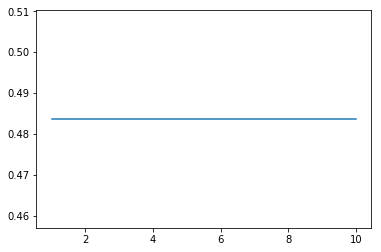

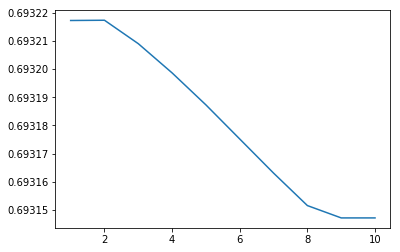

In [11]:
trainLoop(epochs=10, lr=0.001, wd=1e-6, print_batch_p=0.5)